In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

68606236/68606236 [==============================] - 2s 0us/step


In [4]:
path_to_zip

'/root/.keras/datasets/cats_and_dogs.zip'

In [5]:
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
PATH

'/root/.keras/datasets/cats_and_dogs_filtered'

In [6]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [9]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [11]:
class_names = train_dataset.class_names

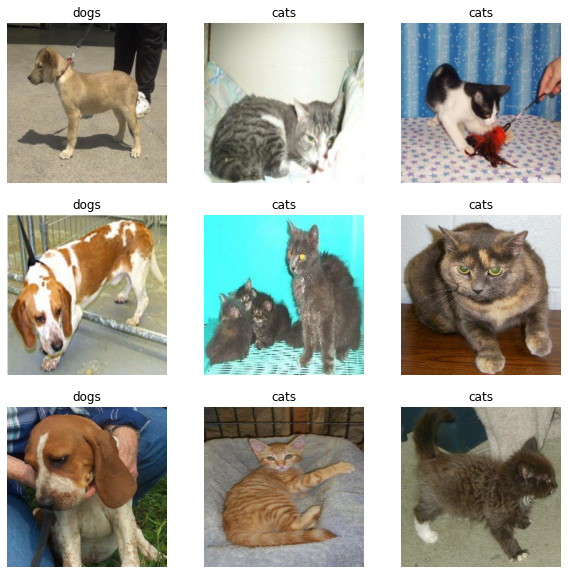

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print(val_batches)

tf.Tensor(32, shape=(), dtype=int64)


In [15]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),tf.keras.layers.RandomRotation(0.2),])

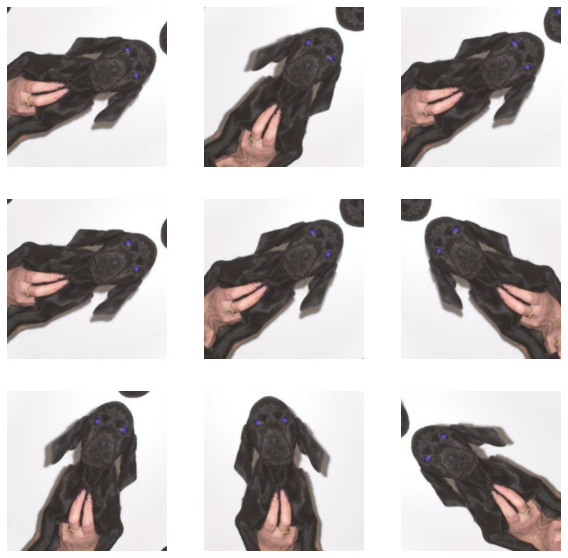

In [18]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [24]:
inputs = tf.keras.Input(shape=(224, 224, 3))
y = data_augmentation(inputs)
y = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(y)
y = tf.keras.layers.MaxPooling2D()(y)
y = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(y)
y = tf.keras.layers.MaxPooling2D()(y)
y = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(y)
y = tf.keras.layers.MaxPooling2D()(y)
y = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(y)
y = tf.keras.layers.MaxPooling2D()(y)
y = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(y)
y = tf.keras.layers.MaxPooling2D()(y)
y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.Dense(1000, activation='relu')(y)
outputs = tf.keras.layers.Dense(1)(y)
model_CNN = tf.keras.Model(inputs, outputs)

In [25]:
model_CNN.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                       

In [26]:
base_learning_rate = 0.0001
model_CNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
history_CNN = model_CNN.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 18s 143ms/step - loss: 4.5161 - accuracy: 0.5245 - val_loss: 0.6558 - val_accuracy: 0.5829
Epoch 2/20
63/63 [==============================] - 9s 131ms/step - loss: 0.6516 - accuracy: 0.5695 - val_loss: 0.6664 - val_accuracy: 0.6634
Epoch 3/20
63/63 [==============================] - 8s 130ms/step - loss: 0.6492 - accuracy: 0.5960 - val_loss: 0.5922 - val_accuracy: 0.6609
Epoch 4/20
63/63 [==============================] - 9s 132ms/step - loss: 0.6049 - accuracy: 0.6475 - val_loss: 0.5692 - val_accuracy: 0.6832
Epoch 5/20
63/63 [==============================] - 8s 128ms/step - loss: 0.5888 - accuracy: 0.6640 - val_loss: 0.5549 - val_accuracy: 0.6782
Epoch 6/20
63/63 [==============================] - 9s 131ms/step - loss: 0.5693 - accuracy: 0.6790 - val_loss: 0.5749 - val_accuracy: 0.6510
Epoch 7/20
63/63 [==============================] - 9s 131ms/step - loss: 0.5570 - accuracy: 0.6915 - val_loss: 0.5905 - val_accuracy: 0.6621
Epoch

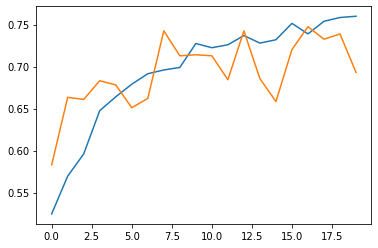

In [29]:
plt.plot(history_CNN.history['accuracy'])
plt.plot(history_CNN.history['val_accuracy'])

**TRANSFER LEARNING**

In [41]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [42]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [43]:
base_model.trainable = False

In [44]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [45]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [46]:
prediction_layer = tf.keras.layers.Dense(1)

In [47]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
outputs_t = prediction_layer(x)
model_t = tf.keras.Model(inputs, outputs_t)

In [48]:
model_t.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0   

In [49]:
base_learning_rate = 0.0001
model_t.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
history_t = model_t.fit(train_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 23s 299ms/step - loss: 2.9046 - accuracy: 0.4415 - val_loss: 3.1118 - val_accuracy: 0.4443
Epoch 2/10
63/63 [==============================] - 17s 258ms/step - loss: 2.1531 - accuracy: 0.5000 - val_loss: 2.3402 - val_accuracy: 0.5173
Epoch 3/10
63/63 [==============================] - 17s 263ms/step - loss: 1.7026 - accuracy: 0.5615 - val_loss: 1.8679 - val_accuracy: 0.6052
Epoch 4/10
63/63 [==============================] - 17s 268ms/step - loss: 1.3887 - accuracy: 0.6245 - val_loss: 1.3962 - val_accuracy: 0.6696
Epoch 5/10
63/63 [==============================] - 17s 266ms/step - loss: 1.1186 - accuracy: 0.6680 - val_loss: 1.0824 - val_accuracy: 0.7203
Epoch 6/10
63/63 [==============================] - 17s 261ms/step - loss: 0.9731 - accuracy: 0.7045 - val_loss: 0.8396 - val_accuracy: 0.7587
Epoch 7/10
63/63 [==============================] - 17s 267ms/step - loss: 0.8224 - accuracy: 0.7360 - val_loss: 0.7051 - val_accuracy: 0.8181

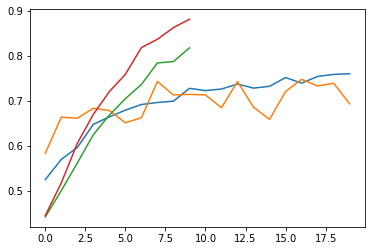

In [51]:
plt.plot(history_CNN.history['accuracy'])
plt.plot(history_CNN.history['val_accuracy'])
plt.plot(history_t.history['accuracy'])
plt.plot(history_t.history['val_accuracy'])

**FINE TUNING**

In [60]:
base_model.trainable = True
fine_tune_at = 13
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [61]:
model_t.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0   

In [62]:
model_t.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [63]:
history_fine = model_t.fit(train_dataset,
                         epochs=20,
                         initial_epoch=history_t.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 22s 306ms/step - loss: 0.2527 - accuracy: 0.9110 - val_loss: 0.1524 - val_accuracy: 0.9517
Epoch 11/20
63/63 [==============================] - 19s 303ms/step - loss: 0.0912 - accuracy: 0.9620 - val_loss: 0.0755 - val_accuracy: 0.9765
Epoch 12/20
63/63 [==============================] - 21s 324ms/step - loss: 0.0779 - accuracy: 0.9695 - val_loss: 0.1062 - val_accuracy: 0.9616
Epoch 13/20
63/63 [==============================] - 20s 308ms/step - loss: 0.0602 - accuracy: 0.9775 - val_loss: 0.0542 - val_accuracy: 0.9790
Epoch 14/20
63/63 [==============================] - 19s 303ms/step - loss: 0.0400 - accuracy: 0.9840 - val_loss: 0.0564 - val_accuracy: 0.9765
Epoch 15/20
63/63 [==============================] - 20s 306ms/step - loss: 0.0346 - accuracy: 0.9855 - val_loss: 0.0886 - val_accuracy: 0.9790
Epoch 16/20
63/63 [==============================] - 20s 308ms/step - loss: 0.0251 - accuracy: 0.9895 - val_loss: 0.0673 - val_accuracy:

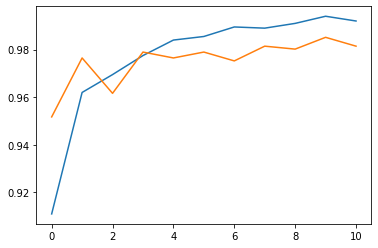

In [77]:
#plt.plot(history_CNN.history['accuracy'])
#plt.plot(history_CNN.history['val_accuracy'])


plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])

In [76]:
model_t.evaluate(test_dataset)

6/6 [==============================] - 1s 165ms/step - loss: 0.0436 - accuracy: 0.9688


[0.0435783714056015, 0.96875]